<a href="https://colab.research.google.com/github/catalinamagalvan/PySimMIBCI/blob/main/PySimMIBCI%20Toolbox/Example_generate_data_for_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/catalinamagalvan/PySimMIBCI.git

Cloning into 'PySimMIBCI'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 139 (delta 29), reused 8 (delta 8), pack-reused 86
Receiving objects: 100% (139/139), 899.82 KiB | 8.74 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
!pip install mne==1.3.0
!pip install fooof==1.0.0
!pip install colorednoise==2.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 27.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 KB 2.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from scipy.io import loadmat
import os
import mne
import numpy as np
from mne.datasets import fetch_fsaverage
import sys
sys.path.insert(1, os.path.join('PySimMIBCI', 'PySimMIBCI Toolbox', 'utils'))
from datasets import (load_and_epoch_OpenBMI_by_ftp, create_OpenBMI_info,
                      raw_from_OpenBMI_data_by_ftp)
from PSD_parameterization import fit_user_params, plot_PSD_FOOOF
from simulation import (set_up_source_forward, generate_when, generate_what,
                        generate_where)
from noise import add_aperiodic_activity, add_eye_movement
from plots import plot_raw_2_channels

Set parameters of data simulation

In [4]:
# MI IDs
MI_tasks_IDs = {'MI/left': 1, 'MI/right': 2}
# Sample frequency
sfreq = 1000
# Number of trials
N_trials = 50
# MI trial duration in ms
MI_duration = 4500
# ERD percentage
reduction = 0.5

Download real MI-EEG data from session 1 of subject 27 of OpenBMI dataset and create corresponding MNE Epochs object.

In [5]:
epochs_real, epochs_real_right, epochs_real_left = load_and_epoch_OpenBMI_by_ftp(subject=27,
                                                                                 session=1,
                                                                                 epoch_window=[0, 4],
                                                                                 picks=None)

Generate suitable mne Info object for OpenBMI data.

In [6]:
info = create_OpenBMI_info()

Fit aperiodic and periodic parameters of real data.

In [7]:
user_params = fit_user_params(epochs_real, epochs_real_right, epochs_real_left)

#Set up source space and compute forward solution.
Here, fsavarage head model is employed, which is a template brain based on a combination of 40 MRI scans of real brains.

In [8]:
subject = 'fsaverage'
fwd, source_simulator = set_up_source_forward(subject, info)

Generate when, what and where information for the task-related component in right hand MI vs left hand MI scenario.

In [9]:
events_info = {0: {'label': 'MI/left', 'duration': MI_duration},
               1: {'label': 'MI/right', 'duration': MI_duration}}
when = generate_when(events_info, N_trials, sfreq)

what = generate_what(MI_tasks_IDs.keys(), when, user_params, MI_duration,
                     sfreq, N_trials, reduction)
where = generate_where(subject)

#Add task-related component to source simulator object.

In [10]:
for label in what.keys():
    for task_ID, task in enumerate(MI_tasks_IDs.keys(), 1):
        when_task = when[np.where(when[:, 2] == task_ID)[0]]
        source_simulator.add_data(label=where[label],
                                  waveform=what[label][task],
                                  events=when_task)

Simulate raw data. Project the source time series to sensor space.
The `mne.simulation.SourceSimulator` object can be given directly to the `mne.simulation.simulate_raw` function.

In [11]:
raw_sim = mne.simulation.simulate_raw(info, source_simulator, forward=fwd)
raw_sim.set_eeg_reference(ref_channels='average')

<RawArray | 62 x 225000 (225.0 s), ~106.5 MB, data loaded>

#Add non-task-related components.

Add aperiodic activity (background noise) to raw simulated data. Here, user-specific aperiodic parameters are employed.

In [12]:
raw_sim = add_aperiodic_activity(raw_sim,
                                 exponent=user_params['aperiodic_params'][1],
                                 offset=user_params['aperiodic_params'][0])

Add eog artifacts by MNE function.

In [13]:
mne.simulation.add_eog(raw_sim)

Add eye-movement artifacts

In [14]:
add_eye_movement(raw_sim)

Epoch data

In [15]:
epochs_sim = mne.Epochs(raw_sim, when, MI_tasks_IDs, tmin=0, tmax=4,
                        baseline=None)
epochs_sim_right = epochs_sim['MI/right']
epochs_sim_left = epochs_sim['MI/left']

FOOOF analysis

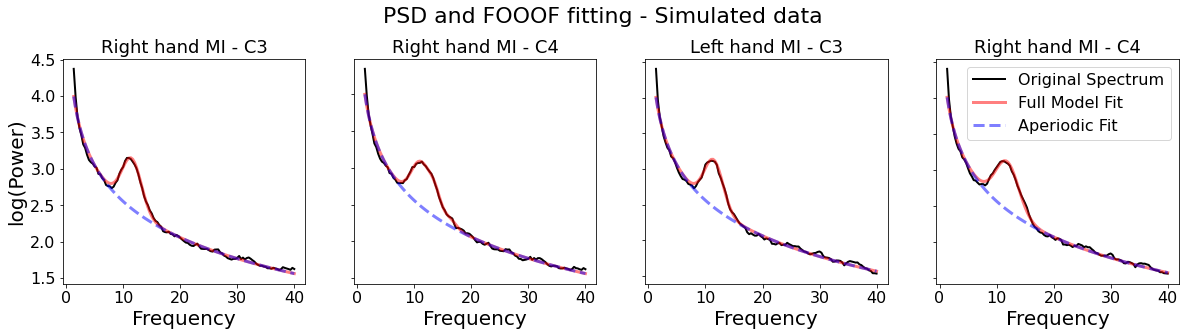

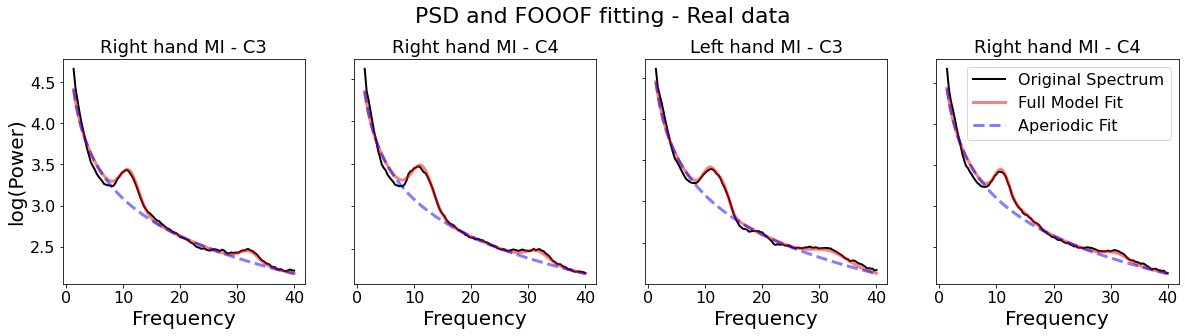

In [16]:
plot_PSD_FOOOF(epochs_sim_right, epochs_sim_left, title = 'Simulated data')
plot_PSD_FOOOF(epochs_real_right, epochs_real_left, title = 'Real data')


Plot some EEG channels

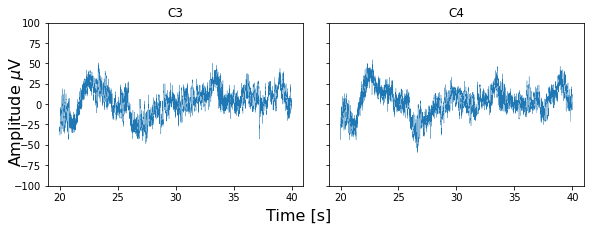

In [19]:
# Real data
raw_real = raw_from_OpenBMI_data_by_ftp(27, 1)
raw_real.filter(l_freq=0.05, h_freq=200, picks='eeg', method='iir',
                phase='zero')
plot_raw_2_channels(raw_real, start=20, duration=20)

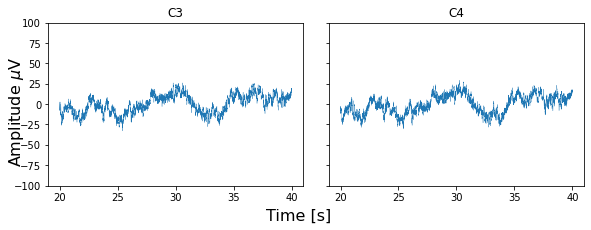

In [18]:
# Simulated data
raw_sim.filter(l_freq=0.05, h_freq=200, picks='eeg', method='iir',
               phase='zero')
plot_raw_2_channels(raw_sim, start=20, duration=20)